<div class="alert alert-success">
    
## Домашнее задание №5: сверточный классификатор.

### Общая информация

Дату мягкого и жесткого дедлайна см. на стр. в `notion`

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

**Если вы отправляете своё решение после мягкого дедлайна просим отписывать проверяющему в личные сообщения в тг о том, что загрузили решение в гугл форму.**

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдача задания после жесткого дедлайна приведет к умножению вашего результата на коэффициент 0.4, что значительно снижает итоговый результат. 

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Обсуждать задачи вместе можно, но тогда напишите, с кем обсуждали задачу. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. 

**Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.**

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [15]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=8)
    
    return train_loader, val_loader, test_loader
    

In [16]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

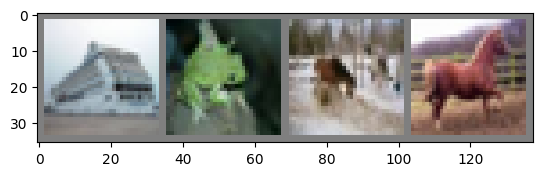

ship frog horse horse


In [17]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [18]:
n_classes = 10


class BasicBlockNet(nn.Module):

    def __init__(self):
        super(BasicBlockNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.shortcut = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=1, stride=1, bias=False)

        self.avg_pool = nn.AvgPool2d(kernel_size=8)

        self.fc = nn.Linear(32 * 4 * 4, n_classes)

    def forward(self, x):
        skip_connection_res = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += skip_connection_res
        out = self.relu(out)


        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)


        out = self.fc(out)

        return out

In [19]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (avg_pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [20]:
# Количество параметров в модели
sum(p.numel() for p in net.parameters() if p.requires_grad)

15434

Проверим, что выход сети имеет корректную размерность:

In [21]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [24]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss_log.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / target.size(0)
        acc_log.append(acc)
        
    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / target.size(0)
        acc_log.append(acc)

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, model_name='model.pt', scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}")

        current_lr = optimizer.param_groups[0]['lr']
        print(f" learning rate: {current_lr}\n")
        
        if scheduler is not None:
            scheduler.step(val_loss)

    torch.save(net, model_name)

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [25]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, model_name='baseline_lr01.pt')

KeyboardInterrupt: 

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 68.73009554140127 %


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

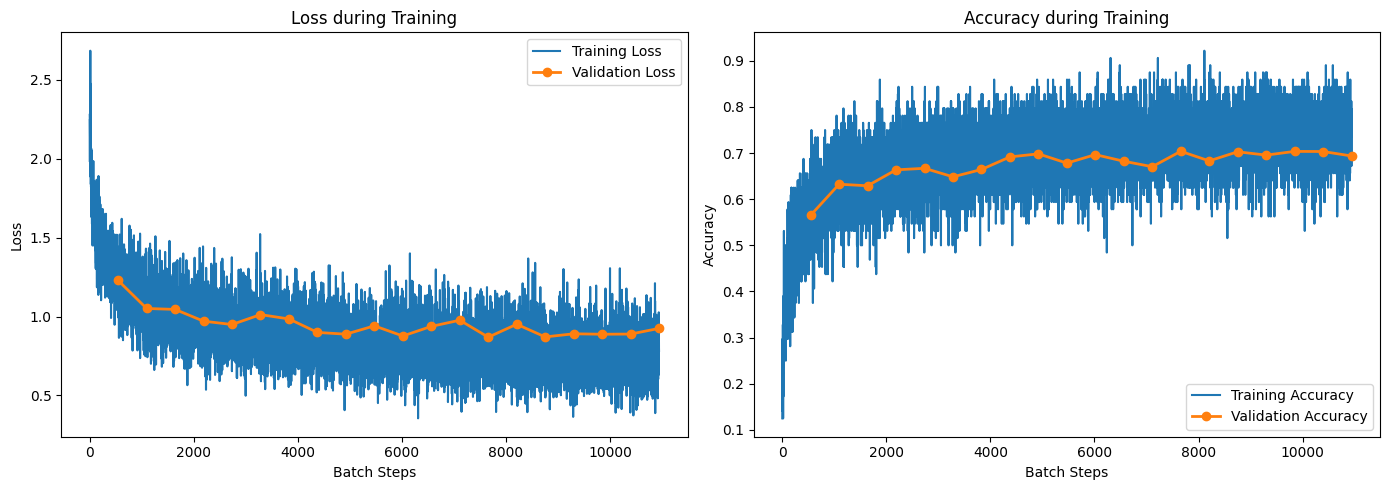

In [ ]:
batch_steps = list(range(1, len(train_loss_log) + 1))
epoch_steps = list(range(1, len(val_loss_log) + 1))

val_steps_scaled = [x * (len(train_loss_log) / len(val_loss_log)) for x in epoch_steps]


plt.figure(figsize=(14, 5))

# Функция потерь
plt.subplot(1, 2, 1)
plt.plot(batch_steps, train_loss_log, label='Training Loss')
plt.plot(val_steps_scaled, val_loss_log, label='Validation Loss', linewidth=2, marker='o')
plt.xlabel('Batch Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss during Training')

# Точность классификации
plt.subplot(1, 2, 2)
plt.plot(batch_steps, train_acc_log, label='Training Accuracy')
plt.plot(val_steps_scaled, val_acc_log, label='Validation Accuracy', linewidth=2, marker='o')
plt.xlabel('Batch Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy during Training')


plt.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С первой недели модуля Вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_sch_mslr.pt')

Epoch 0
 train loss: 1.493355861638538, train acc: 0.4693661856881692
 val loss: 1.2350568043424728, val acc: 0.5646498226950354



/home/maxim/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.1921249565956145, train acc: 0.582609689213894
 val loss: 1.1526420562825304, val acc: 0.5965647163120567

Epoch 2
 train loss: 1.07410670252997, train acc: 0.6287664860276835
 val loss: 1.0781444306069232, val acc: 0.621232269503546

Epoch 3
 train loss: 1.0114947123762894, train acc: 0.6471377970749543
 val loss: 1.0182785622617032, val acc: 0.6478501773049646

Epoch 4
 train loss: 0.963910271197394, train acc: 0.6651663293288064
 val loss: 1.0417037682330355, val acc: 0.6322251773049646

Epoch 5
 train loss: 0.9266719863336309, train acc: 0.6784653303734657
 val loss: 1.0770501623762414, val acc: 0.6348847517730497

Epoch 6
 train loss: 0.9039906493270637, train acc: 0.6877978910942805
 val loss: 0.9678416805064425, val acc: 0.6694592198581562

Epoch 7
 train loss: 0.8788370759221275, train acc: 0.696293908331157
 val loss: 0.9502928698316534, val acc: 0.6731382978723405

Epoch 8
 train loss: 0.8594167329493563, train acc: 0.7017661269260904
 val loss: 0.91696

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 70.3125 %


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, model_name='model_nosch.pt')

Epoch 0
 train loss: 1.8343175065582806, train acc: 0.35769375163227995
 val loss: 1.6204930772172643, val acc: 0.43357712765957446

Epoch 1
 train loss: 1.543653671876604, train acc: 0.45955210237659966
 val loss: 1.453213617649484, val acc: 0.485438829787234

Epoch 2
 train loss: 1.4228069228707545, train acc: 0.5008732697832332
 val loss: 1.3688132767981671, val acc: 0.5200576241134752

Epoch 3
 train loss: 1.3493461515175578, train acc: 0.5256186341081223
 val loss: 1.311813829807525, val acc: 0.5425975177304965

Epoch 4
 train loss: 1.2954418931626315, train acc: 0.5458303408200574
 val loss: 1.2762605547904968, val acc: 0.5564937943262412

Epoch 5
 train loss: 1.248383728416136, train acc: 0.5624102246017237
 val loss: 1.2165953988724567, val acc: 0.5774379432624114

Epoch 6
 train loss: 1.2116850810687327, train acc: 0.5767620462261687
 val loss: 1.206156391793109, val acc: 0.575886524822695

Epoch 7
 train loss: 1.1811568051631098, train acc: 0.5878737921128232
 val loss: 1.172

In [ ]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 66.25199044585987 %


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# Scheduler: ExponentialLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_sch_exp.pt')

Epoch 0
 train loss: 1.4823627810809468, train acc: 0.4758300143640638
 val loss: 1.2683799632052157, val acc: 0.5606161347517731

Epoch 1
 train loss: 1.1401275698184095, train acc: 0.6007320775659442
 val loss: 1.1230638790637888, val acc: 0.6107491134751774

Epoch 2
 train loss: 1.0958961032644268, train acc: 0.6172752350483155
 val loss: 1.0906159527758335, val acc: 0.6217198581560285

Epoch 3
 train loss: 1.0622474285322743, train acc: 0.6305375097936798
 val loss: 1.0582245651711808, val acc: 0.6368794326241135

Epoch 4
 train loss: 1.0314587077885267, train acc: 0.6401802037085401
 val loss: 1.0330992297923312, val acc: 0.6439051418439715

Epoch 5
 train loss: 1.0050021013350547, train acc: 0.6500514168190128
 val loss: 1.0086809381525568, val acc: 0.6514406028368795

Epoch 6
 train loss: 0.98659687689497, train acc: 0.6544871376338469
 val loss: 0.991363967986817, val acc: 0.6587544326241136

Epoch 7
 train loss: 0.9642519122721727, train acc: 0.6653213959258292
 val loss: 0.97

In [ ]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 69.73527070063695 %


In [ ]:
# Scheduler: CosineAnnealingLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", 0.1, 2)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_sch_plateau.pt')

Epoch 0
 train loss: 1.491269908395938, train acc: 0.4651916296683207
 val loss: 1.3227364327045197, val acc: 0.5391843971631205

Epoch 1
 train loss: 1.176307656756267, train acc: 0.5865067576390702
 val loss: 1.1400752681366941, val acc: 0.6007313829787234

Epoch 2
 train loss: 1.0546117329074434, train acc: 0.6345651606163489
 val loss: 1.0379141000991172, val acc: 0.6400044326241136

Epoch 3
 train loss: 0.9988000931208051, train acc: 0.6513286758944894
 val loss: 0.9676974727752361, val acc: 0.6642508865248226

Epoch 4
 train loss: 0.951970524391265, train acc: 0.6699121833376861
 val loss: 0.9788253269297011, val acc: 0.6596631205673759

Epoch 5
 train loss: 0.9302615344088517, train acc: 0.6764086576129538
 val loss: 0.9844907955920442, val acc: 0.6600842198581561

Epoch 6
 train loss: 0.8987065684424894, train acc: 0.6865287934186471
 val loss: 0.9481533991529586, val acc: 0.6714317375886524

Epoch 7
 train loss: 0.8803843588890061, train acc: 0.6916949595194568
 val loss: 0.92

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70d0fc010700>
Traceback (most recent call last):
  File "/home/maxim/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/maxim/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x70d0fc010700>
Traceback (most recent call last):
  File "/home/maxim/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/maxim/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if

Epoch 15
 train loss: 0.7767816115123044, train acc: 0.7298821493862627
 val loss: 0.9017047471188484, val acc: 0.6940824468085106

Epoch 16
 train loss: 0.7729844832333176, train acc: 0.7301351527814051
 val loss: 0.8650696853373913, val acc: 0.7084219858156029

Epoch 17
 train loss: 0.7678319375955208, train acc: 0.7323876991381562
 val loss: 0.8534711500431629, val acc: 0.7108377659574469

Epoch 18
 train loss: 0.7587317768790822, train acc: 0.7351462522851919
 val loss: 0.8574880813030487, val acc: 0.706892730496454

Epoch 19
 train loss: 0.7503127802769488, train acc: 0.7388066401149125
 val loss: 0.8844024724148689, val acc: 0.6978723404255319



In [ ]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 68.86942675159236 %


In [ ]:
# Scheduler: CyclicLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.001, 0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_sch_cycle.pt')

Epoch 0
 train loss: 1.8135754926984882, train acc: 0.36627546356751106
 val loss: 1.6000086520580534, val acc: 0.4490026595744681

Epoch 1
 train loss: 1.5232510259426053, train acc: 0.46472642987725254
 val loss: 1.4299575694063877, val acc: 0.4968306737588653

Epoch 2
 train loss: 1.4029977116767842, train acc: 0.5042194437189867
 val loss: 1.3517429311224756, val acc: 0.5263297872340426

Epoch 3
 train loss: 1.3302656745561952, train acc: 0.5356285910159311
 val loss: 1.279245076280959, val acc: 0.5512854609929078

Epoch 4
 train loss: 1.2692879448207248, train acc: 0.5581948615826586
 val loss: 1.232310064295505, val acc: 0.571764184397163

Epoch 5
 train loss: 1.2161468680423617, train acc: 0.5735015669887699
 val loss: 1.1905751847206278, val acc: 0.5886303191489362

Epoch 6
 train loss: 1.177920112117335, train acc: 0.5887837881953512
 val loss: 1.1895843886314554, val acc: 0.5835106382978723

Epoch 7
 train loss: 1.136618052365793, train acc: 0.6045271284930791
 val loss: 1.10

In [ ]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 66.98845541401273 %


Your answers here:

**Our answers there:**

Мы привыкли называть это скоростью обучения (learning_rate). 

Мы выбрали: 

`ExponentialLR` - каждую эпоху уменьшает learning rate, умножая на определенную величину гамма, скорость обучения при этом будет значительно снижаться в течение первых нескольких эпох, а затем ее изменение замедлится.

`ReduceLROnPlateau` - уменьшает скорость обучения, когда целевая метрика перестает улучшаться (aka выходит на плато).

`CyclicLR` - цикличная скорость обучения, которая варирутся в рамках max/min значений, заданных заранее. Но не просто так, а по циклу - сначала уменьшаясь, а потом увеличиваясь тд.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

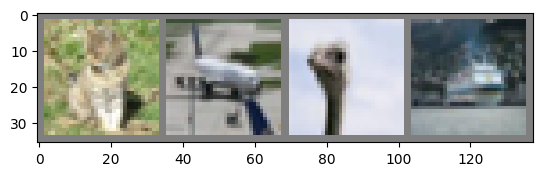

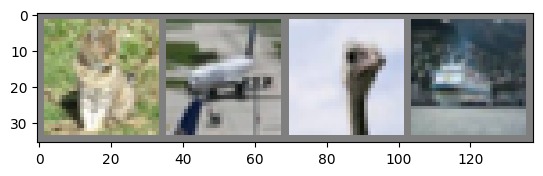

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_aug.pt')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4883080404898803, train acc: 0.47071689736223565
 val loss: 1.2475887998621515, val acc: 0.5607491134751774



/home/maxim/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.1891328826464944, train acc: 0.5804550796552624
 val loss: 1.1456414785790952, val acc: 0.6071808510638298

Epoch 2
 train loss: 1.071158491061418, train acc: 0.6270566727605119
 val loss: 1.110510212309817, val acc: 0.6106826241134753

Epoch 3
 train loss: 1.01687993950992, train acc: 0.6443874053277618
 val loss: 0.9939757070642836, val acc: 0.6576241134751774

Epoch 4
 train loss: 0.9723770038737239, train acc: 0.6645256594411073
 val loss: 0.9953194932734712, val acc: 0.6554964539007093

Epoch 5
 train loss: 0.941399717625142, train acc: 0.6741438691564378
 val loss: 0.9694795600911404, val acc: 0.6692597517730497

Epoch 6
 train loss: 0.9215653288081098, train acc: 0.6810688169234788
 val loss: 0.9654580988782517, val acc: 0.6613031914893617

Epoch 7
 train loss: 0.9088591285989751, train acc: 0.6853331483416035
 val loss: 0.9335853926678921, val acc: 0.6795656028368795

Epoch 8
 train loss: 0.8890299922914348, train acc: 0.6912093562287804
 val loss: 0.9629

Посчитайте точность на тестовой выборке:

In [ ]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 72.19347133757962 %


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),  
     transforms.RandomRotation(degrees=10),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_aug_custom.pt')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7118672932305763, train acc: 0.3804558957952468
 val loss: 1.5470536947250366, val acc: 0.43933953900709216



/home/maxim/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.4882610940410188, train acc: 0.46546911726299295
 val loss: 1.4288739305861453, val acc: 0.4840868794326241

Epoch 2
 train loss: 1.357191438212909, train acc: 0.5146619548184904
 val loss: 1.3588498313376245, val acc: 0.5142287234042553

Epoch 3
 train loss: 1.2753284533237408, train acc: 0.547552396186994
 val loss: 1.2501804889516628, val acc: 0.5665336879432625

Epoch 4
 train loss: 1.2246290321106013, train acc: 0.5684374183860016
 val loss: 1.221208768448931, val acc: 0.5715425531914894

Epoch 5
 train loss: 1.197621599956666, train acc: 0.5764641551318883
 val loss: 1.1403986291682466, val acc: 0.6001994680851064

Epoch 6
 train loss: 1.1697287961595455, train acc: 0.5869148276312354
 val loss: 1.1767894293399568, val acc: 0.5845079787234042

Epoch 7
 train loss: 1.150924120023438, train acc: 0.5944722838861322
 val loss: 1.1855013380659387, val acc: 0.5892287234042554

Epoch 8
 train loss: 1.1351225152747941, train acc: 0.6000383585792635
 val loss: 1.227

In [ ]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 68.1329617834395 %


In [ ]:
transforms_list = [
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4), 
  transforms.RandomRotation(degrees=10),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
]

for i, tr in enumerate(transforms_list):
    transform = transforms.Compose([
        tr,
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    train_loader, val_loader, test_loader = get_cifar10_data(
        batch_size=64, transform_train=transform)

    net = BasicBlockNet().to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[10, 15], gamma=0.1)

    tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
        net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name=f'model_aug_custom_{i}.pt')
    
    print(f"Полученная точность на {transform}:", test(net, test_loader)[1] * 100,"%")

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4883080404898803, train acc: 0.47071689736223565
 val loss: 1.2475887998621515, val acc: 0.5607491134751774



/home/maxim/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.1891328826464944, train acc: 0.5804550796552624
 val loss: 1.1456414785790952, val acc: 0.6071808510638298

Epoch 2
 train loss: 1.071158491061418, train acc: 0.6270566727605119
 val loss: 1.110510212309817, val acc: 0.6106826241134753

Epoch 3
 train loss: 1.01687993950992, train acc: 0.6443874053277618
 val loss: 0.9939757070642836, val acc: 0.6576241134751774

Epoch 4
 train loss: 0.9723770038737239, train acc: 0.6645256594411073
 val loss: 0.9953194932734712, val acc: 0.6554964539007093

Epoch 5
 train loss: 0.941399717625142, train acc: 0.6741438691564378
 val loss: 0.9694795600911404, val acc: 0.6692597517730497

Epoch 6
 train loss: 0.9215653288081098, train acc: 0.6810688169234788
 val loss: 0.9654580988782517, val acc: 0.6613031914893617

Epoch 7
 train loss: 0.9088591285989751, train acc: 0.6853331483416035
 val loss: 0.9335853926678921, val acc: 0.6795656028368795

Epoch 8
 train loss: 0.8890299922914348, train acc: 0.6912093562287804
 val loss: 0.9629

Your answers here:

**Our answers here:**

`transforms.RandomCrop()`: Обрезает изображение до заданного размера, сначала расширяя изображение до большего размера и заполняя края, если требуется.

`transforms.RandomRotation()`: Вращает изображение на случайный угол в пределах заданных границ.

`transforms.ColorJitter()`: Случайным образом изменяет яркость, контрастность и насыщенность изображения.


## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>
import wandb
import datetime

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss_log.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / target.size(0)
        acc_log.append(acc)

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / target.size(0)
        acc_log.append(acc)

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, model_name=None, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}")

        current_lr = optimizer.param_groups[0]['lr']
        print(f" learning rate: {current_lr}\n")

        # Логгирование в wandb
        wandb.log({"Epoch": epoch})
        wandb.log({"Train loss": np.mean(train_loss), "Train accuracy": np.mean(train_acc)})
        wandb.log({"Validation loss": np.mean(val_loss), "Validation accuracy": np.mean(val_acc)})
        
        if scheduler is not None:
            scheduler.step(val_loss)
        
        if model_name is None:
            model_name = f'model_wb_{datetime.datetime.now()}'


    torch.save(net, model_name)

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
wandb.finish()

Epoch,▁▅█
Train accuracy,▁▆█
Train loss,█▃▁
Validation accuracy,▁▆█
Validation loss,█▃▁
Epoch,2
Train accuracy,0.63466
Train loss,1.05455
Validation accuracy,0.61104
Validation loss,1.11637


In [ ]:
wandb.init()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, model_name='baseline_wandb.pt')
wandb.finish() 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: maximelkin14. Use `wandb login --relogin` to force relogin


Epoch 0
 train loss: 1.451125722371682, train acc: 0.4825101201358057
 val loss: 1.245368905777627, val acc: 0.5592641843971631
Current learning rate: 0.1

Epoch 1
 train loss: 1.1583518928540035, train acc: 0.5950354204753199
 val loss: 1.1615544055370575, val acc: 0.5978501773049646
Current learning rate: 0.1

Epoch 2
 train loss: 1.0545518056130279, train acc: 0.6346630974144685
 val loss: 1.1163725586647684, val acc: 0.6110372340425532
Current learning rate: 0.1



KeyboardInterrupt: 